# CNN for RPS Classification
---

### Load basic libraries

In [1]:
# our basic libraries
import torch
import torch.nn as nn
import torchvision
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch. autograd import Variable


# data loading and transforming
from torch.utils.data import DataLoader, Dataset
# import tranform
from torchvision import transforms, datasets
# import split randomsampler
from torch.utils.data.sampler import SubsetRandomSampler

import os
basedir=os.path.abspath(os.path.dirname('_file_'))
# data_folder=os.path.join(basedir,'data') #this is folder weher the images are saved

# da version de opencv
#cv2.__version__

### envia a directorio

In [2]:
# Define a small dataset with 30 png images in a subdirectory of working directory with name databasecorta
traindata_folder='C:/Users/manel/Documents/AI/AI Saturdays 2020/Project2020/RPStraindatabase/'
testdata_folder='C:/Users/manel/Documents/AI/AI Saturdays 2020/Project2020/RPStestdatabase/'
print(traindata_folder) # indica en que directorio estas
print(testdata_folder) # indica en que directorio estas
print(os.listdir(traindata_folder))  # indica contenido del directorio
print(os.listdir(testdata_folder))  # indica contenido del directorio

C:/Users/manel/Documents/AI/AI Saturdays 2020/Project2020/RPStraindatabase/
C:/Users/manel/Documents/AI/AI Saturdays 2020/Project2020/RPStestdatabase/
['paper', 'README_rpc-cv-images.txt', 'rock', 'scissors']
['paper', 'README_rpc-cv-images.txt', 'rock', 'scissors']


## Fichero copiado

In [ ]:
# %pdoc torch.utils.data.DataLoader
# da información de la funcion que se utiliza

In [3]:
batch_size=28
n_iters = 3000

### upload the dataset .png

In [4]:
def trainload_images(image_size=28,batch_size=batch_size, root=traindata_folder):
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    
   
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      
    train_set = torchvision.datasets.ImageFolder(root=traindata_folder, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_set, train_loader

In [5]:
def testload_images(image_size=28,batch_size=batch_size, root=testdata_folder):
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    
       
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      
    test_set= datasets.ImageFolder(root=testdata_folder, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

    return test_set, test_loader

There are 3 “dimensions” for each image, each consisting of 28 by 28 pixels; the 3 dimensions are the color codes for “red,green, blue”.

In [6]:
train_set, train_loader=trainload_images (image_size=28,batch_size=batch_size,
                                                            root=traindata_folder)
test_set, test_loader=testload_images (image_size=28,batch_size=batch_size,
                                                            root=testdata_folder)
print("num iter", n_iters)
print("train_set length", len(train_set))
print("test_set length", len(test_set))
print("batch size",batch_size)
num_epochs=n_iters / (len(train_set) /batch_size)
num_epochs = int(num_epochs)

num iter 3000
train_set length 1756
test_set length 432
batch size 28


In [7]:
train_set[0][0].numpy().shape

(3, 28, 28)

In [8]:
test_set[0][0].numpy().shape

(3, 28, 28)

https://www.reddit.com/r/learnmachinelearning/comments/92nh4c/how_do_i_load_images_into_pytorch_for_training/

https://medium.com/swlh/rock-paper-scissor-image-classifier-using-torch-vision-and-a-cnn-f54d3ed0a65e

https://github.com/xijianlim/torch_and_keras/blob/master/CNN_RPS_torch.ipynb

0


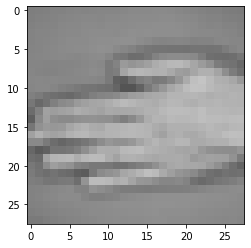

In [9]:
### a sample of the image ###
plt.imshow(train_set[0][0].permute(1, 2, 0)  )
print(train_set[0][1])

0


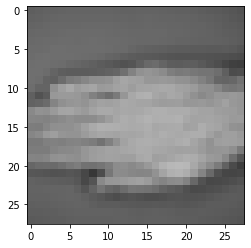

In [10]:
### a sample of the image ###
plt.imshow(test_set[0][0].permute(1, 2, 0)  )
print(test_set[0][1])

In [11]:
train_set.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}

In [12]:
test_set.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}

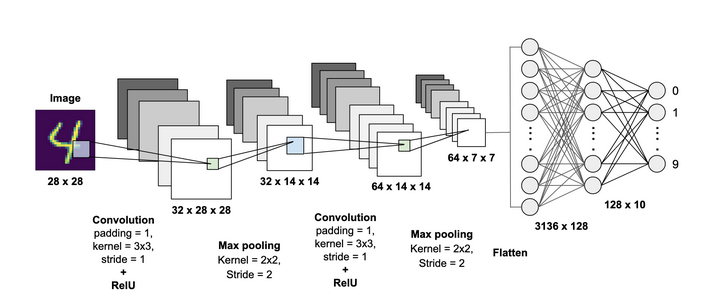

In [13]:
### calculating padding
height=28
width = 28
kernel_size = 5 # we
padding = int((kernel_size-1)/2) # = 2
stride=1

print("padding",padding)


#output_after_1_convolution
# output= (W−F+2P)/S+1 W= Size (28x28)=28, F= Number of kernel (5x5)=5 P= Padding=2 stride=1
out1=(height-kernel_size+(2*padding))/1 + 1 #=(28-5+2x2/1 +1 =28
print("size conv1",out1)

#output maxpool
output_pool1 = out1/padding #=14  # no se si la formula es correcta.
print("output maxpool1", output_pool1 )

#output_after_2_convolution
out2=(output_pool1-kernel_size+(2*padding))/1 + 1 #= 14
print("size conv2",out2)

#output maxpool2
output_pool2 = out2/padding #=7
print("output maxpool2", output_pool2 )

#output max pool2
# atention 32 is the number of output channels of the conv2
print("input de fully connected", 32 * output_pool2 * output_pool2)

padding 2
size conv1 28.0
output maxpool1 14.0
size conv2 14.0
output maxpool2 7.0
input de fully connected 1568.0


output= (W−F+2P)/S+1
W= Size (28x28)=28, F= Number of kernel (3x3)=3 P= Padding S=stride

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
    
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, 
                              kernel_size=kernel_size, stride=1, padding=padding)
        self.relu1 = nn.ReLU() 
        #inchannel = 1 because it is one grey scale #out_channels=number of kernels you're choosing ,so 16 feature maps
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #maxpool kernel = (kernel_size-1)/2 = (5-1)/2 = 2
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(int(32 * output_pool2 * output_pool2), 3) 
        ## so out_channels * output pools, and 3 represents the number of labels (rock paper or scissors)
        
        # 32*7*7 = final conv output X output_pool2 X output_pool2
        # '3' refers to the labels len(torch.unique(test_dataset.test_labels)))
        
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [15]:
model = CNNModel()

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
print(model.parameters())

print('length of parameters :',len(list(model.parameters())))

# Convolution 1: 16 Kernels
print("\n first out, first input , kernel dimensions :")
print(list(model.parameters())[0].size())

# Convolution 1 Bias: 16 Kernels
print(list(model.parameters())[1].size())

print("\n second out, second input , kernel dimensions :")
# Convolution 2: 32 Kernels with depth = 16
print(list(model.parameters())[2].size())

# Convolution 2 Bias: 32 Kernels with depth = 16

print(list(model.parameters())[3].size())

# Fully Connected Layer 1

print('\nnumber of labels=3, 1569= 32*7*7 as per max pooling calcs above')
print(list(model.parameters())[4].size())

# Fully Connected Layer Bias
print(list(model.parameters())[5].size())

<generator object Module.parameters at 0x00000196DFFABB10>
length of parameters : 6

 first out, first input , kernel dimensions :
torch.Size([16, 3, 5, 5])
torch.Size([16])

 second out, second input , kernel dimensions :
torch.Size([32, 16, 5, 5])
torch.Size([32])

number of labels=3, 1569= 32*7*7 as per max pooling calcs above
torch.Size([3, 1568])
torch.Size([3])


### Train NN

In [17]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images
        images = images.requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images
                images = images.requires_grad_()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            testaccuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Train Loss: {}. Test Accuracy: {:.3f}'.format(iter, loss.item(), testaccuracy))
            # print('Iteration: {}. Loss: {:.4f}. Accuracy: {:.3f}'.format(iter, loss.item(), accuracy))
            # print('Epoch: {}. Iteration: {}. Loss: {:.4f}. Accuracy: {:.3f}'.format(epoch, iter, loss.item(), accuracy))
             

Iteration: 500. Train Loss: 0.829341471195221. Test Accuracy: 78.000
Iteration: 1000. Train Loss: 0.20962384343147278. Test Accuracy: 87.000
Iteration: 1500. Train Loss: 0.2773328125476837. Test Accuracy: 88.000
Iteration: 2000. Train Loss: 0.10166692733764648. Test Accuracy: 90.000
Iteration: 2500. Train Loss: 0.12382681667804718. Test Accuracy: 92.000


## Testing One Single Image

In [21]:
test_set[0][0].numpy().shape

(3, 28, 28)

tensor([-0.3292,  1.0564, -0.7937], grad_fn=<SliceBackward>)

 predicted label is : 1
predicted label is Rock

 correct label is:  1
correct label is Rock

 correct Prediction


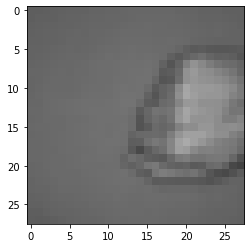

In [47]:
## Testing from a Single Image taken from the dataset
## n is test image
n=200
test_image=test_set[n][0]
printing_image=test_image
test_image = Variable(test_image, requires_grad=True)
test_image = test_image.unsqueeze(0)
outputs=model(test_image)
print(outputs[0,:])
#print('\n predicted label is :', torch.max(outputs.data, 1)[1][0])

pred_label=int(torch.max(outputs.data, 1)[1][0])
print('\n predicted label is :', pred_label)

if pred_label == 0:
    print("predicted label is Paper")
elif pred_label == 1:
    print("predicted label is Rock")
else:
    print("predicted label is Scissors")

print('\n correct label is: ',test_set[n][1])

actual_label=test_set[n][1]

if actual_label == 0:
    print("correct label is Paper")
elif actual_label == 1:
    print("correct label is Rock")
else:
    print("correct label is Scissors")



if (torch.max(outputs.data, 1)[1][0])==(test_set[n][1]):
    print("\n correct Prediction")
else:
    print("Bad predition")
    
    
plt.imshow(printing_image.detach().permute(1, 2, 0))

In [49]:
## saving model and dataset

save_model = True
if save_model is True:
    # Saves only parameters
    # alpha & beta
    torch.save(model.state_dict(), "RPSclassModel.pth")

## DE AQUI ADELANTE YA NO ES MODELO

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.linear_1 = torch.nn.Linear(12*4*4, 120)
        self.linear_2 = torch.nn.Linear(120, 10)
        self.dropout = torch.nn.Dropout(p=0.1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)

        return F.log_softmax(x)
    
    # instantiate and print your Net
net = Net()
print(net)

### TODO: Specify the loss function and optimizer

Learn more about [loss functions](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizers](http://pytorch.org/docs/master/optim.html) in the online documentation.

Note that for a classification problem like this, one typically uses cross entropy loss, which can be defined in code like: `criterion = nn.CrossEntropyLoss()`. PyTorch also includes some standard stochastic optimizers like stochastic gradient descent and Adam. You're encouraged to try different optimizers and see how your model responds to these choices as it trains.


In [ ]:
import torch.optim as optim

## TODO: specify loss function (try categorical cross-entropy)
criterion = torch.nn.CrossEntropyLoss()
## criterion = torch.nn.BCELoss(size_average=True)  
## TODO: specify optimizer 
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### A note on accuracy

It's interesting to look at the accuracy of your network **before and after** training. This way you can really see that your network has learned something. In the next cell, let's see what the accuracy of an untrained network is (we expect it to be around 10% which is the same accuracy as just guessing for all 10 classes).

In [ ]:
print(labels.size())
print(images.size())

In [ ]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct / total

# print it out!
print('Accuracy before training: ', accuracy)

### Train the Network

Below, we've defined a `train` function that takes in a number of epochs to train for. The number of epochs is how many times a network will cycle through the training dataset. 

Here are the steps that this training function performs as it iterates over the training dataset:

1. Zero's the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss (how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network’s parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss



In [ ]:
def train(n_epochs):
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data       

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            if batch_i % 1000 == 999:    # print every 1000 mini-batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [ ]:
# define the number of epochs to train for
# start small to see if your model works, initially
n_epochs = 4

# call train
train(n_epochs)

### Test the Trained Network

Once you are satisfied with how the loss of your model has decreased, there is one last step: test!

You must test your trained model on a previously unseen dataset to see if it generalizes well and can accurately classify this new dataset. For FashionMNIST, which contains many pre-processed training images, a good model should reach **greater than 85% accuracy** on this test dataset. If you are not reaching this value, try training for a larger number of epochs, tweaking your hyperparameters, or adding/subtracting layers from your CNN.

In [ ]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

### Visualize sample test results

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Question: What are some weaknesses of your model? (And how might you improve these in future iterations.)

**Answer**: Double-click and write answer, here.

### Save Your Best Model

Once you've decided on a network architecture and are satisfied with the test accuracy of your model after training, it's time to save this so that you can refer back to this model, and use it at a later data for comparison of for another classification task!

In [ ]:
## TODO: change the model_name to something uniqe for any new model
## you wish to save, this will save it in the saved_models directory
model_dir = '/savedmodels/modelfashion_1.pt'
# model_name = 'modelfashion_1.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
# torch.save(net.state_dict(), model_dir+model_name)
torch.save(net.state_dict(), model_dir)

### Load a Trained, Saved Model

To instantiate a trained model, you'll first instantiate a new `Net()` and then initialize it with a saved dictionary of parameters (from the save step above).

In [ ]:
# instantiate your Net
# this refers to your Net class defined above
net = Net()

# load the net parameters by name
# uncomment and write the name of a saved model
net.load_state_dict(torch.load('saved_models/model_1.pt'))

print(net)

# Once you've loaded a specific model in, you can then 
# us it or further analyze it! 
# This will be especialy useful for feature visualization 